## Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import random
import tensorflow as tf
from tensorflow import keras

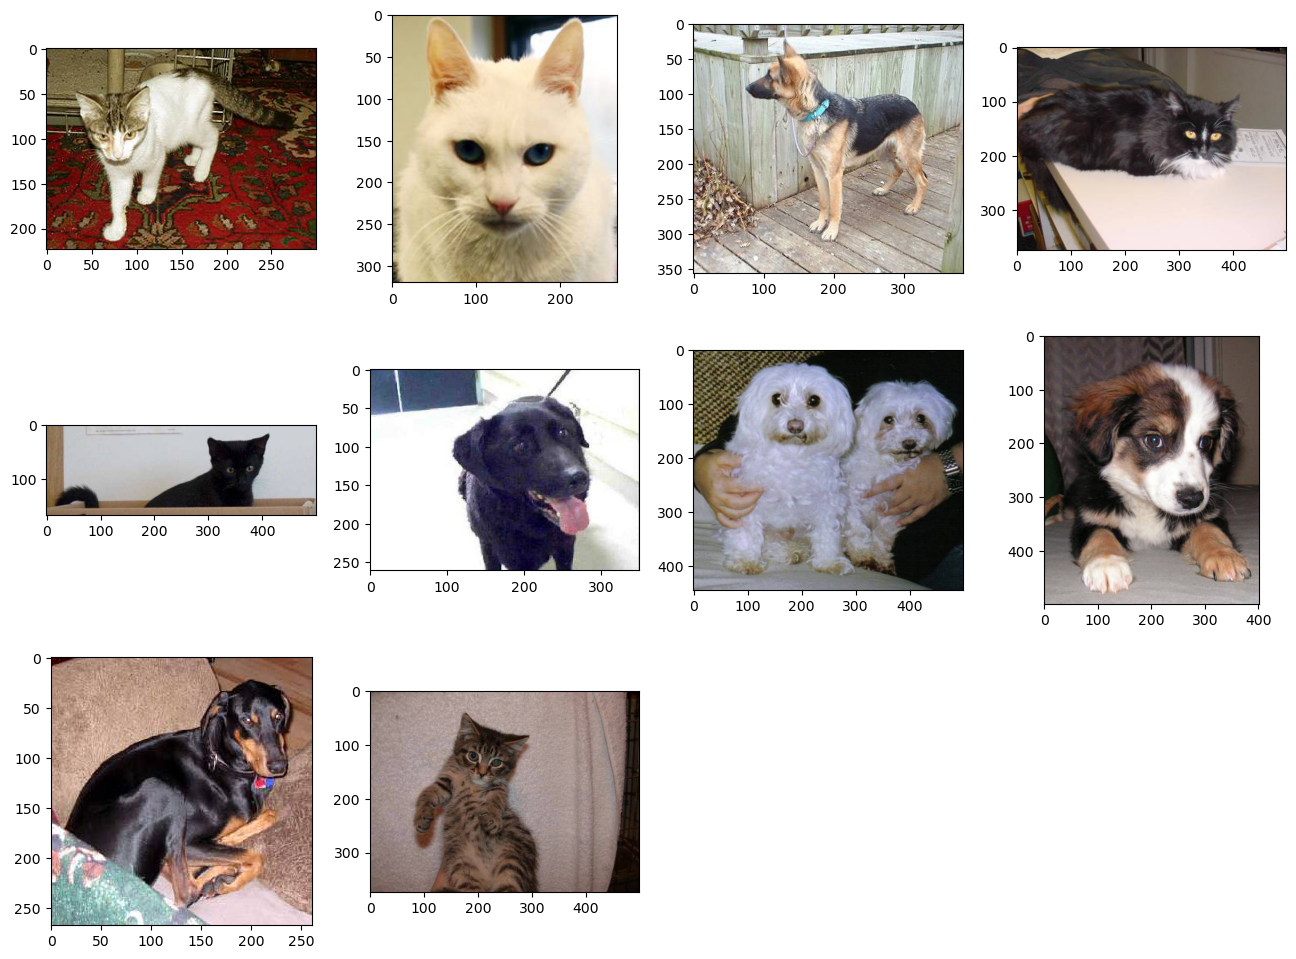

In [2]:
main_dir = "dataset"
train_dir = "train"
path = os.path.join(main_dir, train_dir)
images = os.listdir(path)
plt.figure(figsize=(16, 16))

for i in range(10):
   img = random.choice([x for x in images])
   fig = plt.subplot(4, 4, i + 1)
   img = mpimg.imread(os.path.join(path, img))
   fig.imshow(img)

In [4]:
X = []
y = []
convert = lambda category : int(category == "dog")

for p in os.listdir(path):
    category = p.split(".")[0]
    category = convert(category)
    img_array = cv2.imread(os.path.join(path, p), )
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    X.append(new_img_array)
    y.append(category)
    
X = np.array(X).reshape(-1, 80, 80, 3)
y = np.array(y)

### Normalize Data

In [5]:
X = X / 255.0

### Define CNN model

In [12]:
model = keras.models.Sequential()

# Adds a densly-connected layer to the model
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(80, 80, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Add another layer
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# And another layer
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Guess what..? Add another layer
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten, then feed the data to the Dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

### Complie the model

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Fit Model with Training Data

In [9]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 101s 158ms/step - loss: 0.6346 - accuracy: 0.6443 - val_loss: 0.8442 - val_accuracy: 0.3832
Epoch 2/10
625/625 [==============================] - 103s 164ms/step - loss: 0.5471 - accuracy: 0.7265 - val_loss: 0.6702 - val_accuracy: 0.6256
Epoch 3/10
625/625 [==============================] - 106s 170ms/step - loss: 0.4756 - accuracy: 0.7743 - val_loss: 0.7176 - val_accuracy: 0.6032
Epoch 4/10
625/625 [==============================] - 105s 168ms/step - loss: 0.4159 - accuracy: 0.8097 - val_loss: 0.7662 - val_accuracy: 0.6398
Epoch 5/10
625/625 [==============================] - 106s 170ms/step - loss: 0.3726 - accuracy: 0.8359 - val_loss: 0.5145 - val_accuracy: 0.7602
Epoch 6/10
625/625 [==============================] - 107s 171ms/step - loss: 0.3392 - accuracy: 0.8521 - val_loss: 0.3755 - val_accuracy: 0.8340
Epoch 7/10
625/625 [==============================] - 104s 166ms/step - loss: 0.3009 - accuracy: 0.8706 - val_loss: 1.1006 -

### Pre-process Test Data

In [10]:
train_dir = "test"
path = os.path.join(main_dir, train_dir)

X_test = []
id_line = []

for p in os.listdir(path):
    id_line.append(p.split(".")[0])
    img_array = cv2.imread(os.path.join(path, p))
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    X_test.append(new_img_array)
    
X_test = np.array(X_test).reshape(-1, 80, 80, 3)
X_test = X_test / 255

### Making predictions With Test Data

In [11]:
predictions = model.predict(X_test)
predicted_val = [int(round(p[0])) for p in predictions]

391/391 [==============================] - 13s 32ms/step


### Make Data Frame from Results

In [11]:
df = pd.DataFrame({"id": id_line, "label": predicted_val})

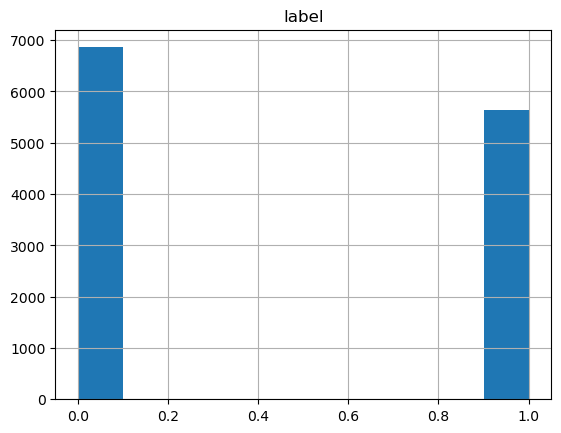

In [13]:
df.hist()
plt.show()